In [1]:
#!pip install tensorflow[and-cuda]

In [1]:
import os

print(os.getcwd())  # Check the current working directory
print(os.listdir(os.getcwd()))  # List all files in the directory

p:\Krati Maheshwari
['.idea', 'app.py', 'best_model.h5', 'Code.ipynb', 'Dataset', 'efficientnet.h5', 'efficientnet.keras', 'ensemble_model.h5', 'ensemble_model_tf', 'Fold1-20250503T135641Z-1-001.zip', 'inceptionV3.h5', 'inceptionV3.keras', 'M04_01.jpg', 'mobilenetv2.h5', 'mobilenetv2.keras', 'monk', 'monk2', 'monk3', 'NM03_01_04.jpg', 'resnet.pkl', 'resnet50.h5', 'resnet50.keras', 'Test_Data', 'xception.h5', 'xception.keras']


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')

# Print the name of each GPU
for gpu in gpus:
  print("Name:", gpu.name)

Num GPUs Available:  0


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
#!pip install pandas
#!pip install seaborn
#!pip install pillow

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip
import tensorflow.keras.layers as tfl
import seaborn as sns
from PIL import Image

dataset_path = 'Dataset'
import os

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"The directory {dataset_path} does not exist. Please check the dataset path.")

print("Contents of the dataset directory:")
print(os.listdir(dataset_path))

Contents of the dataset directory:
['Monkeypox_augmented', 'Normal_image_augmented']


In [7]:
# # train_path = os.path.join(dataset_path, 'Fold1/Train')
# # test_path = os.path.join(dataset_path, 'Fold1/Test')
# 
# train_path = os.path.join(dataset_path, 'Train')
# val_path = os.path.join(dataset_path, 'Val')
# test_path = os.path.join(dataset_path, 'Test')
# 
# train_path, val_path, test_path

Class: Monkeypox_augmented


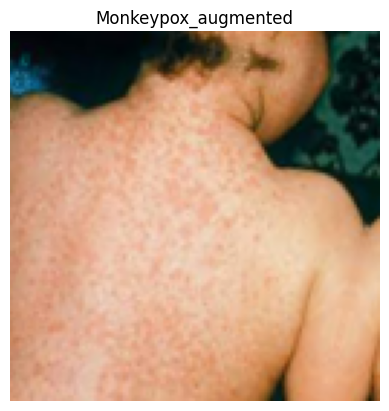

Class: Normal_image_augmented


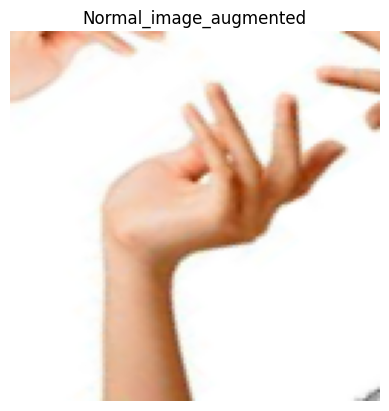

In [4]:
# Visualize image samples from Train
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    images = os.listdir(folder_path)
    print("Class:", folder)
    if len(images) > 0:
        img = mpimg.imread(os.path.join(folder_path, images[0]))
        plt.imshow(img)
        plt.title(folder)
        plt.axis('off')
        plt.show()

In [ ]:
import os
import shutil
import random

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  
def create_test_split(dataset_path, test_path, test_split_ratio=0.15, seed=42):
    """
    Create a test split by copying a percentage of images from each class folder.

    Parameters:
    - dataset_path: path to dataset with class folders
    - test_path: target path where test set will be created
    - test_split_ratio: float (e.g., 0.15 for 15% test)
    - seed: random seed for reproducibility
    """
    random.seed(seed)

    if not os.path.exists(test_path):
        os.makedirs(test_path)

    class_folders = os.listdir(dataset_path)

    for class_folder in class_folders:
        class_dir = os.path.join(dataset_path, class_folder)
        if not os.path.isdir(class_dir):
            continue

        images = os.listdir(class_dir)
        images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

        num_test = int(len(images) * test_split_ratio)
        test_images = random.sample(images, num_test)

        # Create destination class folder in Test path
        test_class_dir = os.path.join(test_path, class_folder)
        os.makedirs(test_class_dir, exist_ok=True)

        for img in test_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(test_class_dir, img)
            shutil.copy2(src, dst)

    print(f" Test set created at '{test_path}' with {test_split_ratio*100:.0f}% samples from each class.")



Accuracy = {}

# Load datasets without using validation_split/subset
img_size = 128
BATCH_SIZE = 16
SEED = 22

train_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,           # 20% for validation
    subset="training",
    seed=SEED,
    image_size=(img_size, img_size),
    batch_size=BATCH_SIZE,
    label_mode='binary',            # binary labels (0 or 1)
    shuffle=True
)

val_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(img_size, img_size),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)


test_path = "../Krati Maheshwari/Test_Data"  
#test_dataset = create_test_split(dataset_path, test_path, test_split_ratio=0.10)

# Load test set
test_dataset = image_dataset_from_directory(
    test_path,
    image_size=(128, 128),  # or whatever your model input size is
    batch_size=16,
    label_mode='binary',
    shuffle=False
)


AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    tfl.RandomFlip('horizontal_and_vertical'),
    tfl.RandomRotation(0.2),
    tfl.RandomZoom(0.2),
    tfl.RandomContrast(0.2)
])

augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

Found 1139 files belonging to 2 classes.
Using 912 files for training.
Found 1139 files belonging to 2 classes.
Using 227 files for validation.
Found 170 files belonging to 2 classes.


## ResNet50

In [6]:
import tensorflow as tf
from tensorflow.keras import layers as tfl
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    tfl.RandomFlip('horizontal'),
    tfl.RandomRotation(0.3),
    tfl.RandomZoom(0.3),
    tfl.RandomContrast(0.3)
])

# Build model
def get_model(base, preprocessor, img_size):
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = data_augmentation(inputs)
    x = preprocessor(x)
    x = base(x)
    x = tfl.GlobalAveragePooling2D()(x)  # Replaces Flatten
    x = tfl.Dense(128, activation='relu')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dropout(0.2)(x)
    x = tfl.Dense(64, activation='relu')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dropout(0.2)(x)
    outputs = tfl.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Load ResNet50
img_size = 128
pre_trained_model = ResNet50(input_shape=(img_size, img_size, 3),
                              include_top=False,
                              weights='imagenet')

# Freeze first 140 layers (fine-tuning from layer 141 onward)
pre_trained_model.trainable = True
for layer in pre_trained_model.layers[:140]:
    layer.trainable = False

# Create the model
model = get_model(pre_trained_model, preprocess_input, img_size)

# Compile with lower LR for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Add callbacks:
- EarlyStopping: Stop training if no improvement in validation loss.
- ModelCheckpoint: Save the best model.
- ReduceLROnPlateau: Reduce learning rate when validation loss plateaus.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

In [8]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.7997 - loss: 0.4520

57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 938ms/step - accuracy: 0.8011 - loss: 0.4493 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0100
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 876ms/step - accuracy: 0.9161 - loss: 0.2214 - val_accuracy: 0.9956 - val_loss: 0.0259 - learning_rate: 0.0100
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 51s 898ms/step - accuracy: 0.9630 - loss: 0.1239 - val_accuracy: 0.9163 - val_loss: 0.2400 - learning_rate: 0.0100
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 56s 989ms/step - accuracy: 0.9657 - loss: 0.1335 - val_accuracy: 1.0000 - val_loss: 0.0186 - learning_rate: 0.0020


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - accuracy: 0.2011 - loss: 5958.4502
Test accuracy : 0.48235294222831726
Model saved successfully!


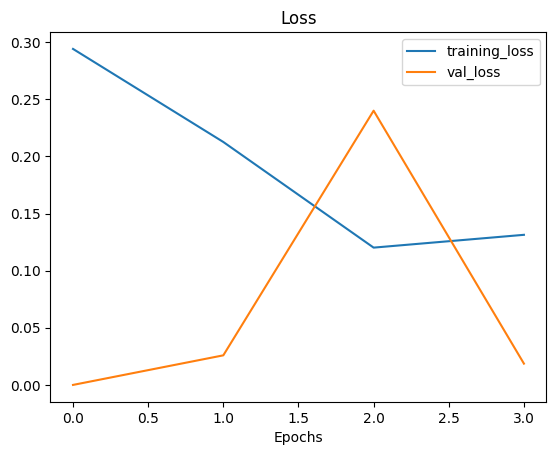

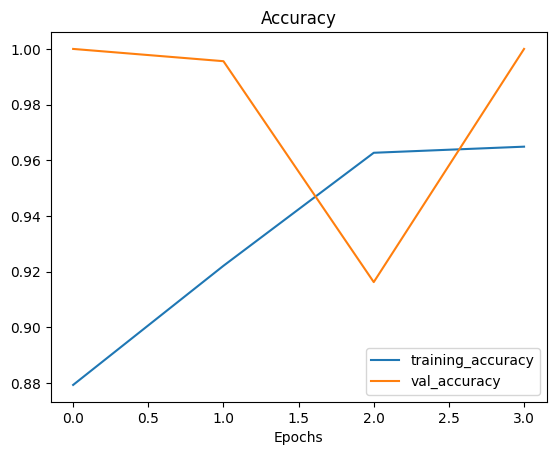

In [9]:
plot_loss_curves(history)

# Save train and val accuracy
Accuracy['ResNet'] = history.history['accuracy'][-1]
Accuracy['ResNet_val'] = history.history['val_accuracy'][-1]

# Evaluate on test set (not validation set)
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy :', test_acc)

# Save final model
model.save('resnet50.keras')  #-----------------------with open('resnet.pkl', 'wb') as file:
                            #                          pickle.dump(model, file)
print("Model saved successfully!")

## XCEPTION

In [10]:
from tensorflow.keras.applications.xception import preprocess_input, Xception

# Load pretrained Xception model
pre_trained_model = Xception(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers
pre_trained_model.trainable = False

# Create model with Xception base
model = get_model(pre_trained_model, preprocess_input, img_size)

# Compile
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=callbacks  # same callbacks used before
)

Epoch 1/5


57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 494ms/step - accuracy: 0.7406 - loss: 0.5542 - val_accuracy: 0.8678 - val_loss: 0.3201 - learning_rate: 0.0010
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 528ms/step - accuracy: 0.8999 - loss: 0.2441 - val_accuracy: 0.9559 - val_loss: 0.1441 - learning_rate: 0.0010
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 540ms/step - accuracy: 0.9043 - loss: 0.2097 - val_accuracy: 0.9339 - val_loss: 0.1982 - learning_rate: 0.0010
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 540ms/step - accuracy: 0.9430 - loss: 0.1662 - val_accuracy: 0.9912 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 651ms/step - accuracy: 0.9431 - loss: 0.1460 - val_accuracy: 0.9868 - val_loss: 0.0747 - learning_rate: 0.0010


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - accuracy: 0.9753 - loss: 0.1341
Test accuracy: 0.9882352948188782
Xception model saved.


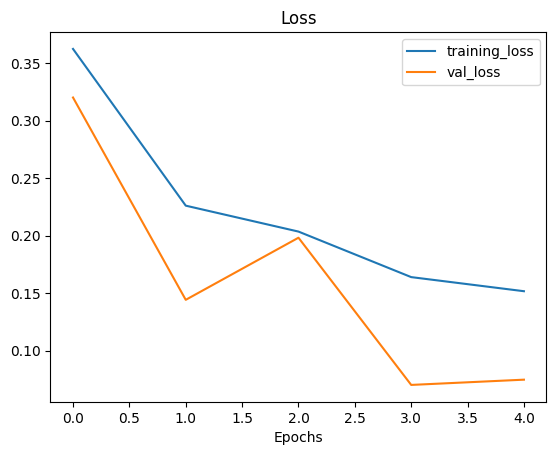

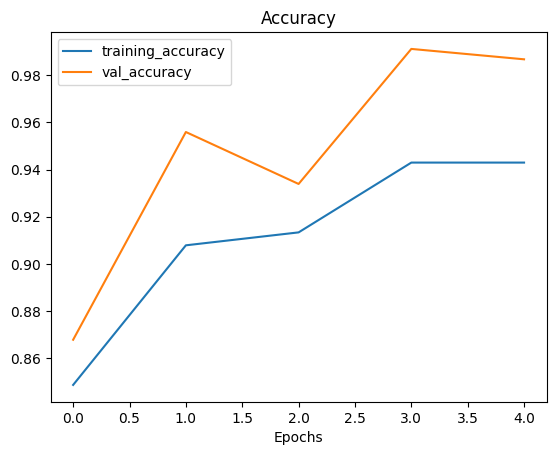

In [12]:
plot_loss_curves(history)

Accuracy['Xception'] = history.history['accuracy'][-1]
Accuracy['Xception_val'] = history.history['val_accuracy'][-1]

test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)

model.save('xception.keras')
print("Xception model saved.")

INCEPTIONV3

In [13]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
pre_trained_model = tf.keras.applications.InceptionV3(input_shape=(img_size,img_size,3),
                                         include_top=False,
                                         weights='imagenet')
pre_trained_model.trainable = False
model = get_model(pre_trained_model, preprocess_input, img_size)

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [14]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5,
                    verbose=1)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.7850 - loss: 0.5105 - val_accuracy: 0.8634 - val_loss: 0.3661
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.9256 - loss: 0.1946 - val_accuracy: 0.9075 - val_loss: 0.2551
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 295ms/step - accuracy: 0.8755 - loss: 0.3251 - val_accuracy: 0.9075 - val_loss: 0.2277
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - accuracy: 0.9183 - loss: 0.1896 - val_accuracy: 0.9295 - val_loss: 0.1739
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step - accuracy: 0.9276 - loss: 0.1878 - val_accuracy: 0.9471 - val_loss: 0.1665


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9601 - loss: 0.0877
test accuracy :  0.9647058844566345


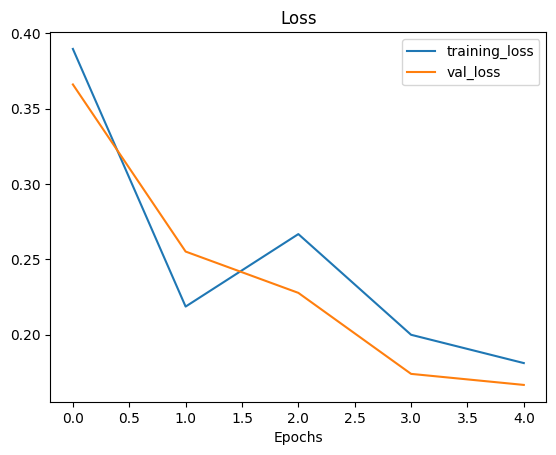

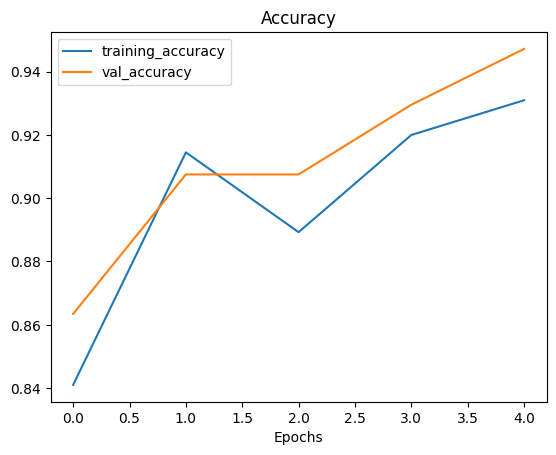

In [15]:
plot_loss_curves(history)

Accuracy['InceptionV3'] = history.history['accuracy'][-1]

# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(test_dataset)
print('test accuracy : ', test_acc)

model.save('inceptionV3.keras')

EFFICIENT

In [16]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
pre_trained_model = tf.keras.applications.EfficientNetB5(input_shape=(img_size,img_size,3),
                                         include_top=False,
                                         weights='imagenet')
pre_trained_model.trainable = False
model = get_model(pre_trained_model, preprocess_input, img_size)
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5,
                    verbose=1
                    )

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 66s 864ms/step - accuracy: 0.7466 - loss: 0.5294 - val_accuracy: 0.9559 - val_loss: 0.2460
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 814ms/step - accuracy: 0.9116 - loss: 0.2102 - val_accuracy: 0.9604 - val_loss: 0.1854
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 836ms/step - accuracy: 0.9332 - loss: 0.1790 - val_accuracy: 0.9868 - val_loss: 0.0903
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 822ms/step - accuracy: 0.9338 - loss: 0.1354 - val_accuracy: 0.9868 - val_loss: 0.0543
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 735ms/step - accuracy: 0.9550 - loss: 0.1266 - val_accuracy: 0.9780 - val_loss: 0.0641


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step - accuracy: 0.9674 - loss: 0.0818
test accuracy :  0.970588207244873
Model saved successfully!


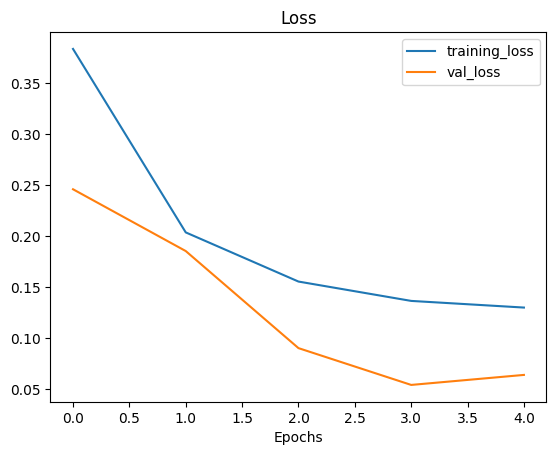

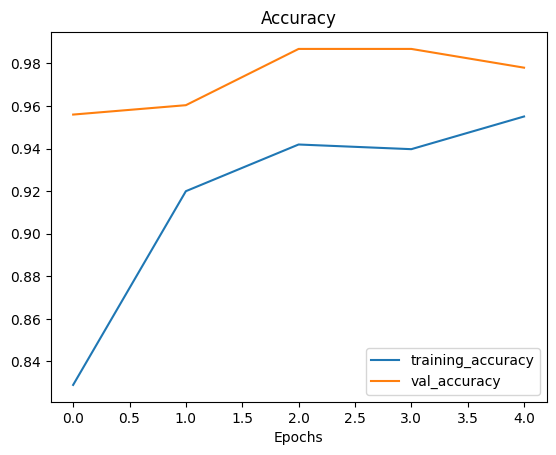

In [18]:
plot_loss_curves(history)

Accuracy['EfficientNet'] = history.history['accuracy'][-1]

# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(test_dataset)
print('test accuracy : ', test_acc)

model.save('efficientnet.keras')

print("Model saved successfully!")

MOBILENET

In [19]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=(img_size,img_size,3),
                                         include_top=False,
                                         weights='imagenet')
pre_trained_model.trainable = False
model = get_model(pre_trained_model, preprocess_input, img_size)
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [20]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5,
                    verbose=1
                    )

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.7850 - loss: 0.4780 - val_accuracy: 0.9383 - val_loss: 0.1796
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9468 - loss: 0.1420 - val_accuracy: 0.9339 - val_loss: 0.1666
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.9515 - loss: 0.1214 - val_accuracy: 0.9912 - val_loss: 0.0392
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.9588 - loss: 0.0992 - val_accuracy: 0.9648 - val_loss: 0.0754
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.9607 - loss: 0.1089 - val_accuracy: 0.9736 - val_loss: 0.0587


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9990 - loss: 0.0089
test accuracy :  0.9941176176071167
Model saved successfully!


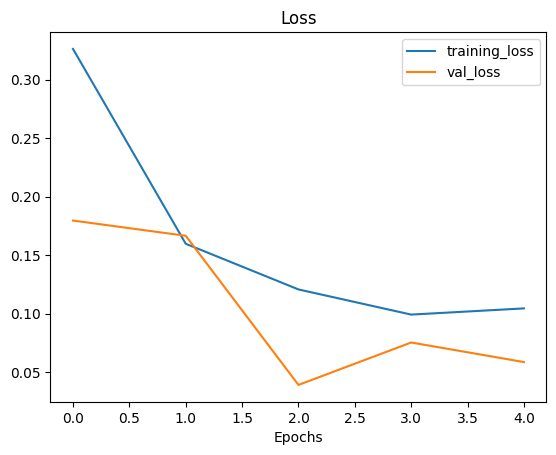

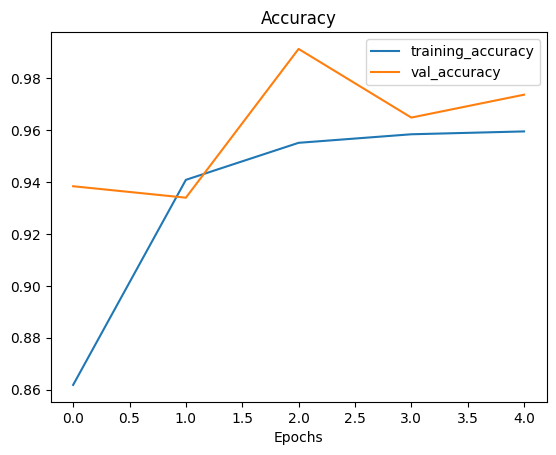

In [21]:
plot_loss_curves(history)

Accuracy['MobilenetV2'] = history.history['accuracy'][-1]

# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(test_dataset)
print('test accuracy : ', test_acc)

model.save('mobilenetv2.keras')

print("Model saved successfully!")

ENSEMBLE STREAMLIT

ENSEMBLE

In [75]:
#pip install tensorflow

In [22]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Concatenate, Dense


def build_loaded_ensemble_model(img_size=(128, 128, 3)):
    # Load saved models
    model_resnet50 = load_model("resnet50.keras")       #---------------------------- pickle.load(open('resnet.pkl','rb'))
    model_inceptionv3 = load_model("inceptionV3.keras")
    model_xception = load_model("xception.keras")
    model_efficientnet = load_model("efficientnet.keras")
    model_mobilenetv2 = load_model("mobilenetv2.keras")

    # Truncate each model to get intermediate features (just before the output layer)
    model_resnet50 = Model(model_resnet50.input, model_resnet50.layers[-2].output)
    model_inceptionv3 = Model(model_inceptionv3.input, model_inceptionv3.layers[-2].output)
    model_xception = Model(model_xception.input, model_xception.layers[-2].output)
    model_efficientnet = Model(model_efficientnet.input, model_efficientnet.layers[-2].output)
    model_mobilenetv2 = Model(model_mobilenetv2.input, model_mobilenetv2.layers[-2].output)

    # Input
    input_layer = Input(shape=img_size)

    # Get feature outputs
    resnet_feat = model_resnet50(input_layer)
    inception_feat = model_inceptionv3(input_layer)
    xception_feat = model_xception(input_layer)
    efficientnet_feat = model_efficientnet(input_layer)
    mobilenet_feat = model_mobilenetv2(input_layer)

    # Concatenate features
    merged = Concatenate()([
        resnet_feat,
        inception_feat,
        xception_feat,
        efficientnet_feat,
        mobilenet_feat
    ])

    # Final classification head
    output = Dense(1, activation='sigmoid')(merged)

    # Ensemble model
    ensemble_model = Model(inputs=input_layer, outputs=output)
    ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return ensemble_model

In [23]:
ensemble_model = build_loaded_ensemble_model(img_size=(128, 128, 3))
ensemble_model.summary()

p:\Krati Maheshwari\monk3\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 54 variables whereas the saved optimizer has 106 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_27       │ (None, 64)        │ 23,859,008 │ input_layer_12[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_28       │ (None, 64)        │ 22,074,080 │ input_layer_12[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_29       │ (None, 64)        │ 21,132,776 │ input_layer_12[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_30       │ (None, 64)        │ 28,784,823 │ input_layer_12[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_31       │ (None, 64)        │  2,430,976 │ input_layer_12[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 320)       │          0 │ functional_27[0]… │
│ (Concatenate)       │                   │            │ functional_28[0]… │
│                     │                   │            │ functional_29[0]… │
│                     │                   │            │ functional_30[0]… │
│                     │                   │            │ functional_31[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │        321 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 98,281,984 (374.92 MB)

 Trainable params: 16,234,625 (61.93 MB)

 Non-trainable params: 82,047,359 (312.99 MB)

In [24]:
# Train if needed (optional, e.g., fine-tuning on small dataset)
ensemble_model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5,
                    verbose=1
                    )

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.8707 - loss: 0.2697 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9858 - loss: 0.0350 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9863 - loss: 0.0476 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9917 - loss: 0.0307 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9922 - loss: 0.0203 - val_accuracy: 1.0000 - val_loss: 3.1225e-04


In [ ]:
ensemble_model.export("ensemble_model_tf")


INFO:tensorflow:Assets written to: ensemble_model_tf\assets


INFO:tensorflow:Assets written to: ensemble_model_tf\assets


Saved artifact at 'ensemble_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_4431')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2582643855904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582643862240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582643903824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582643913856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582644089328: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2582643914912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582644007584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582644004240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582644010400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582644007232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582644008640: Tens

Ensemble model created successfully!

In [2]:
from keras.layers import TFSMLayer
from keras import Input, Model

# Load SavedModel as an inference-only layer
ensemble_layer = TFSMLayer("ensemble_model_tf", call_endpoint="serving_default")

# Re-wrap it into a full model
inputs = Input(shape=(128, 128, 3))
outputs = ensemble_layer(inputs)
model = Model(inputs, outputs)


In [3]:
model.save("ensemble_model.keras")


In [3]:
import pickle
with open('ensemble.pkl', 'wb') as file:
    pickle.dump(model, file)

In [37]:
def predict_single_image(img_path, model, img_size=128):
    try:
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Predict
        raw_pred = model.predict(img_array)

        # Handle dict output (SavedModel via TFSMLayer)
        if isinstance(raw_pred, dict):
            key = list(raw_pred.keys())[0]
            prediction = raw_pred[key][0][0]
        else:
            prediction = raw_pred[0][0]

        label = "No Monkeypox" if prediction > 0.5 else " Monkeypox"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        print(f"{os.path.basename(img_path)} => {label} (Confidence: {confidence:.2f})")
        return label, round(confidence, 2)

    except Exception as e:
        print(f"Error: {e}")
        return None, None


In [38]:
img_path = "Test_Data/Monkeypox_augmented/aug_3_3338.png"
label, confidence = predict_single_image(img_path, model, img_size=128)

if label is not None:
    print(f"Prediction: {label}, Confidence: {confidence}")
else:
    print("Prediction failed.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
aug_3_3338.png =>  Monkeypox (Confidence: 0.57)
Prediction:  Monkeypox, Confidence: 0.5699999928474426


In [39]:
img_path = "Test_Data/Normal_image_augmented/aug_0_1381.png"
label, confidence = predict_single_image(img_path, model, img_size=128)

if label is not None:
    print(f"Prediction: {label}, Confidence: {confidence}")
else:
    print("Prediction failed.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
aug_0_1381.png => No Monkeypox (Confidence: 1.00)
Prediction: No Monkeypox, Confidence: 1.0


In [47]:
img_path = "Test_Data/Normal_image_augmented/aug_0_7455.png"
label, confidence = predict_single_image(img_path, model, img_size=128)

if label is not None:
    print(f"Prediction: {label}, Confidence: {confidence}")
else:
    print("Prediction failed.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
aug_0_7455.png => No Monkeypox (Confidence: 1.00)
Prediction: No Monkeypox, Confidence: 1.0


In [49]:
img_path = "Test_Data/Monkeypox_augmented/aug_4_4846.png"
label, confidence = predict_single_image(img_path, model, img_size=128)

if label is not None:
    print(f"Prediction: {label}, Confidence: {confidence}")
else:
    print("Prediction failed.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
aug_4_4846.png =>  Monkeypox (Confidence: 0.98)
Prediction:  Monkeypox, Confidence: 0.9800000190734863


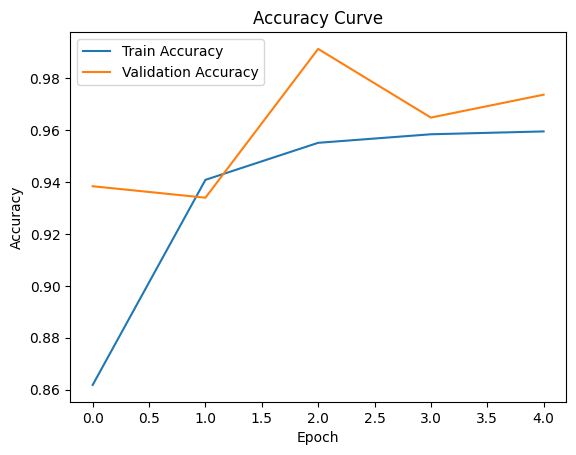

Final Training Accuracy: 0.9594
Final Validation Accuracy: 0.9736


In [43]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# Print final accuracy
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
